In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

import warnings # highly illegal move to make pandas compliant
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append('../code/utils')  # Add the utils directory to the Python path

import utils_data, utils_spikes, utils_events
import dataloader


# And now that we have a dataloader, let's try to fit it using a simple SNN model

In [27]:
# Experiment specific parameters 
chip_id = 9501 # experiment ID
chip_session = 0 # 2 for post-training, 0 for pre-training

# Stable parameters
data_path = '../data/cortical_labs_data/' # path to data
fs = 20000 # sampling frequency
binsize = 10 # ms, bin size for spike counts
array_size = 1024 # number of electrode in the array

# Using our brand new dataloader

Loading data...: 100%|██████████| 29/29 [00:02<00:00, 13.06it/s]


Stimulation mode: full game


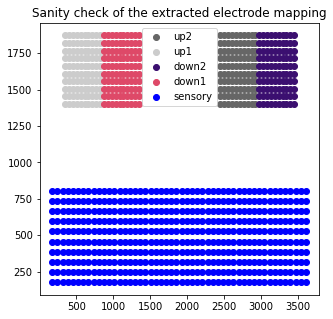

Binning down2 channels: 100%|██████████| 100/100 [00:00<00:00, 535.36it/s]


True

In [45]:
data_subset, events = dataloader.load_file(chip_id, chip_session, data_path)
spiketimes = dataloader.get_spiketimes(data_subset, array_size,fs)
sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes = dataloader.get_electrode_regions(data_subset, spiketimes, do_plot = True)

all_spikes = [sensory_spikes, up1_spikes, up2_spikes, down1_spikes, down2_spikes]
# Find maximum time across all spike lists
max_time_ms = max(max(max(spikes) for spikes in spike_list)*1000 for spike_list in all_spikes)

# Create binned spikes tensor for each region
sensory_spikes_binned = dataloader.spike_times_to_bins(sensory_spikes, binsize, max_time_ms, spike_tag = 'sensory')
up1_spikes_binned = dataloader.spike_times_to_bins(up1_spikes, binsize, max_time_ms, spike_tag = 'up1')
down1_spikes_binned = dataloader.spike_times_to_bins(down1_spikes, binsize, max_time_ms, spike_tag='down1')
up2_spikes_binned = dataloader.spike_times_to_bins(up2_spikes, binsize, max_time_ms, spike_tag = 'up2')
down2_spikes_binned = dataloader.spike_times_to_bins(down2_spikes, binsize, max_time_ms, spike_tag = 'down2')

# Verifying that the tensor are binary files
dataloader.check_binary(sensory_spikes_binned, "sensory_spikes_binned")
dataloader.check_binary(up1_spikes_binned, "up1_spikes_binned")
dataloader.check_binary(down1_spikes_binned, "down1_spikes_binned")
dataloader.check_binary(up2_spikes_binned, "up2_spikes_binned")
dataloader.check_binary(down2_spikes_binned, "down2_spikes_binned")

# And now we fit using SNNTorch, using a pipeline courtesy of Jason Eshraghian

### First we need to get some labels

In [51]:
def events_to_bins(events, event_types, bin_width, max_time_ms):
    num_bins = int(np.ceil(max_time_ms / bin_width))
    event_bins = np.zeros((len(event_types), num_bins))
    event_index = 0  # pointer to track current event
    
    # sort events based on 'norm_timestamp'
    events = sorted(events, key=lambda e: e['norm_timestamp'])

    for bin_index in range(num_bins):
        current_bin_time = bin_width * bin_index
        next_bin_time = bin_width * (bin_index + 1)

        # move the event pointer until an event is in the future
        while event_index < len(events) and events[event_index]['norm_timestamp'] < next_bin_time:
            curr_event = events[event_index]['event']
            curr_event_type_index = event_types.index(curr_event)
            event_bins[curr_event_type_index, bin_index] = 1
            event_index += 1

    return event_bins

In [47]:
events[0]['event'] = 'motor layout: 0' # change the being game to motor layout for convenience 

# First we need to label the data 
for event in events:
    event['norm_timestamp'] /= fs  # fs to seconds 
    event['norm_timestamp'] *= 1000  # seconds to ms

In [62]:
event_types = ['ball missed', 'ball bounce', 'ball return', 'motor layout: 0'] # these are all the labels
labels = torch.tensor(events_to_bins(events, event_types, 10, max_time_ms))

In [63]:
print(labels.shape)
print(up1_spikes_binned.shape)

torch.Size([4, 120002])
torch.Size([100, 120002])


In [64]:
def transform_data(labels, spiketimes, events, bin_width, n_steps):
    n_labels, _ = labels.shape
    n_neurons, _ = spiketimes.shape
    n_trials = len(events)

    # Initialize new tensor
    new_tensor = np.zeros((n_labels, n_neurons, n_steps * n_trials))

    # Sort events based on 'norm_timestamp'
    events = sorted(events, key=lambda e: e['norm_timestamp'])

    # Iterate over trials
    for i in range(n_trials):
        # Get start index for this trial
        start_index = int(events[i]['norm_timestamp'] / bin_width)

        # Get data for this trial
        for j in range(n_steps):
            if start_index + j < labels.shape[1]:
                new_tensor[:, :, i * n_steps + j] = labels[:, start_index + j] * spiketimes[:, start_index + j]
            else:
                # If there is no more data for this trial, fill with zeros
                new_tensor[:, :, i * n_steps + j] = 0

    return new_tensor


In [65]:
new_tensor = transform_data(labels, up1_spikes_binned, events, 10, 10)

RuntimeError: The size of tensor a (4) must match the size of tensor b (100) at non-singleton dimension 0

### And now we can define the network

In [ ]:
from snntorch import functional as SF

In [ ]:
npy_array = sensory_spikes_binned

In [ ]:
npy_array.shape

torch.Size([500, 120002])

In [ ]:
# Load the data from the .npy file
npy_array = np.load('/content/decoding_theta_bt4_data.npy', allow_pickle=True)

# Print the shape of the loaded data
data = npy_array[0]
labels = npy_array[1]

FileNotFoundError: [Errno 2] No such file or directory: '/content/decoding_theta_bt4_data.npy'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[:, idx, :], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

data = torch.from_numpy(data) # Shape (61, 360, 249)
labels = torch.from_numpy(labels) # Shape (360,)

# Create Dataset
dataset = CustomDataset(data, labels)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Change batch_size as needed

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        num_inputs = 249
        num_hidden = 1000
        num_outputs = 12
        beta = 0.95

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(x.size(1)):
            # print(x[:,step].size())
            cur1 = self.fc1(x[:,step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


# Load the network onto CUDA if available
brain_net = Net().to(device)

In [ ]:
loss_fn = SF.ce_count_loss()
optimizer = torch.optim.Adam(brain_net.parameters(), lr=1e-3, betas=(0.9, 0.999))

num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    train_batch = iter(data_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        brain_net.train()
        spk_rec, _ = brain_net(data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print train/test loss/accuracy
        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
          break